<a href="https://colab.research.google.com/github/HsuLiSheng/stock-related/blob/main/4_%E6%8C%87%E6%95%B8%E5%9C%96%E5%BD%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 5.2 MB/s 


In [ ]:
pip install --upgrade mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 1.9 MB/s 


In [ ]:
from urllib.request import urlopen
import datetime
import json
import pandas as pd
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf 


def tableColor(val):
    if val > 0:
        color = 'red'
    elif val < 0:
        color = 'green'
    else:
        color = 'white'
    return 'color: %s' % color  

In [ ]:
###
###台股近兩個月的指數
###

date = datetime.date.today()
today = datetime.date.strftime(date,"%Y%m%d")
name = ['2022'+str((date.month-2)//10)+str(date.month-2)+'01', '2022'+str((date.month-1)//10)+str(date.month-1)+'01', today]
print('查詢月份:'+ str(date.month-2) + '月 ~ '+ str(date.month) + '月')


index = []
for i in range(len(name)):
  html =urlopen ('https://www.twse.com.tw/indicesReport/MI_5MINS_HIST?response=json&date='+name[i])
  content = html.read().decode('utf-8')
  jcontent = json.loads(content) ###利用json把數據整理更好看
  data = jcontent['data']
  ###把指數價格從str轉成float
  for i in range(len(data)):
    for j in range(1,len(data[0])):
      data[i][j] = float(data[i][j].replace(',',''))
  index.extend(data)

print(jcontent['fields'])
len(index)

查詢月份:8月 ~ 10月
['日期', '開盤指數', '最高指數', '最低指數', '收盤指數']


58

In [ ]:
df = pd.DataFrame(index)
df.columns = ['Date','Open','High','Low','Close']

###把日期形式從111改成2022，才能讓datetimeindex讀懂
for i in range(len(df.index)): 
  index1 = '2022'+ df['Date'].iloc[i][3:]
  df['Date'].iloc[i] = index1
df.index = pd.to_datetime(df['Date'])

df = df.drop('Date',axis=1)

df.insert(4,'漲跌',0.0)
for i in range(1,len(df.index)):
  df['漲跌'].iloc[i] = df['Close'].iloc[i] - df['Close'].iloc[i-1] 


###need unique default index(use reset_index)
df1 = df.reset_index(drop=True)
###need unique default index(use reset_index)
df1 = df1[-5:].style.applymap(tableColor, subset=['漲跌'])
display(df1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Open,High,Low,Close,漲跌
53,12988.830000,12988.830000,12814.820000,12966.050000,-162.070000
54,13075.050000,13143.150000,12978.130000,13124.680000,158.630000
55,13096.350000,13155.620000,12976.760000,12976.760000,-147.920000
56,12912.930000,12946.100000,12698.910000,12946.100000,-30.660000
57,12931.200000,12954.020000,12813.600000,12819.200000,-126.900000


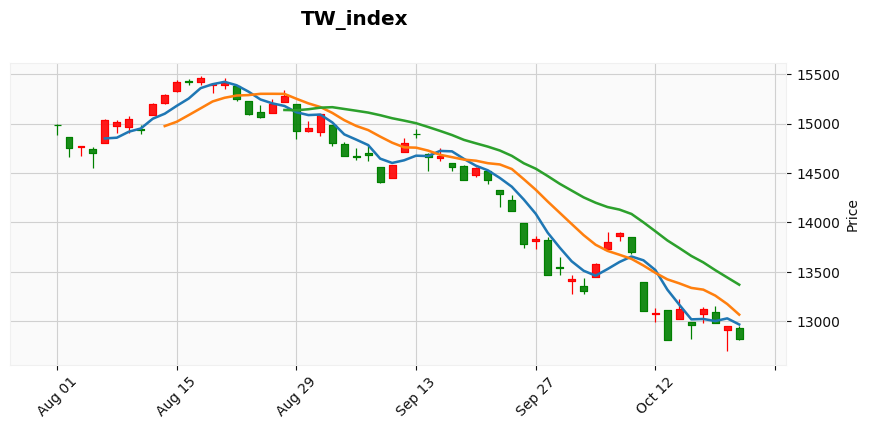

In [ ]:
title = 'TW_index'

#針對線圖的外觀微調，將上漲設定為紅色，下跌設定為綠色，符合台股表示習慣
#接著把自訂的marketcolors放到自訂的style中，而這個改動是基於預設的yahoo外觀
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

#設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值
kwargs = dict(type='candle', mav=(5,10,20,60), figratio=(20,8), figscale=0.75, title = title, style=s)
mpf.plot(df, **kwargs)


In [ ]:
import yfinance as yf

def plot_AMindex(index_code, index_name, dataframe):
    ###有效的讀取period:“1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
    df = yf.Ticker(index_code).history(period='3mo')
    df = df.drop(['Dividends','Stock Splits'],axis=1)
    mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    
    #設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值
    if min(df['Volume']) == 0:
      kwargs = dict(type='candle', mav=(5,10,20,60), figratio=(20,8), figscale=0.75, title=index_name, style=s)
    else:
      kwargs = dict(type='candle', mav=(5,10,20,60), volume = True, figratio=(20,8), figscale=0.75, title=index_name, style=s)  
    mpf.plot(df, **kwargs)
    
    df.insert(4,'漲跌百分比',0.0)
    for i in range(1,len(df.index)):
        df['漲跌百分比'].iloc[i] = (df['Close'].iloc[i] - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1] * 100 
    
    df.insert(4,'漲跌',0.0)
    for i in range(1,len(df.index)):
        df['漲跌'].iloc[i] = df['Close'].iloc[i] - df['Close'].iloc[i-1] 

    df.insert(0,'指數名稱',index_name)    
    dataframe = dataframe.append(df[-1:])
    return dataframe

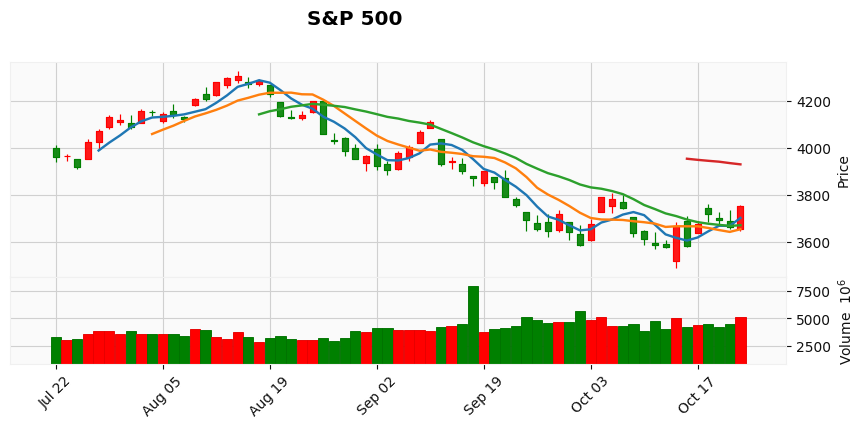

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


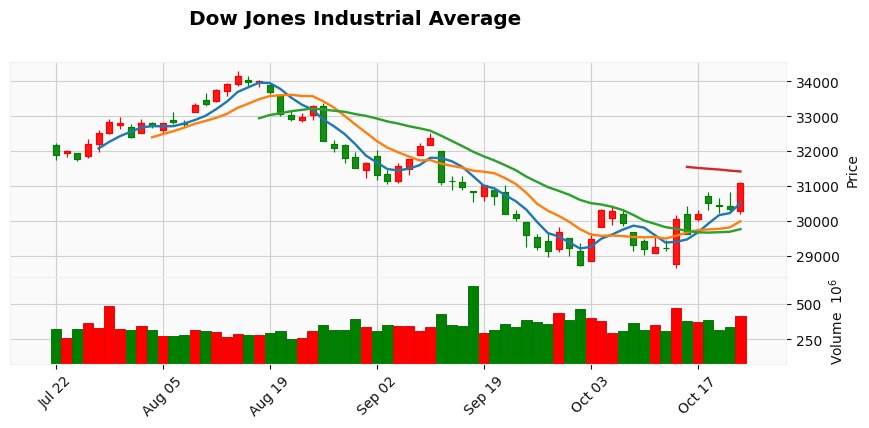

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


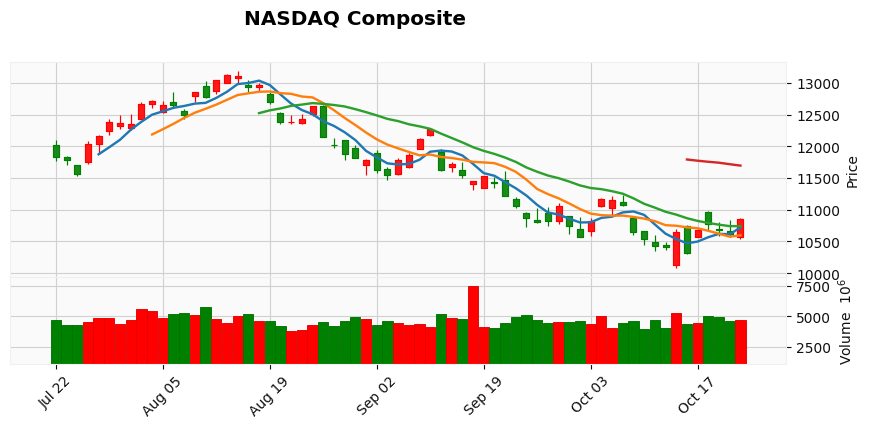

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


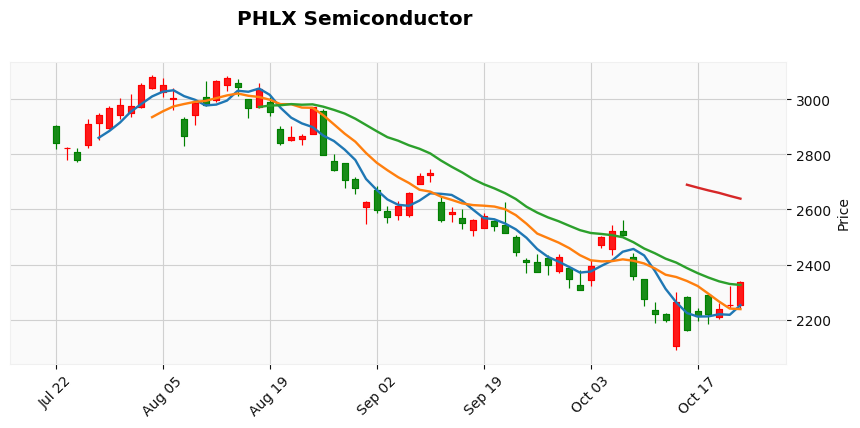

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
index_code = ['^GSPC', '^DJI', '^IXIC', '^SOX']
index_name = ['S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'PHLX Semiconductor']
index_all = pd.DataFrame()
for i in range(len(index_code)):
  index_all = plot_AMindex(index_code[i], index_name[i], index_all)


In [ ]:
###need unique default index(use reset_index)
df_data = index_all.reset_index(drop=True).style.applymap(tableColor, subset=['漲跌','漲跌百分比'])
display(df_data)

,指數名稱,Open,High,Low,Close,漲跌,漲跌百分比,Volume
0,S&P 500,3657.100098,3757.889893,3647.419922,3752.750000,86.969971,2.372482,5078020000
1,Dow Jones Industrial Average,30291.179688,31119.269531,30206.279297,31082.560547,748.970703,2.469113,418190000
2,NASDAQ Composite,10576.040039,10875.719727,10542.429688,10859.719727,244.879883,2.306958,4706440000
3,PHLX Semiconductor,2253.370117,2339.899902,2238.120117,2336.689941,83.469971,3.704475,0
